### Imports

In [37]:
from pathlib import Path
path_folder = Path("/Users/keithlowton/Desktop/Ks/Python code/Kaggle/House prices")
print(path_folder.exists())
print(path_folder)

True
/Users/keithlowton/Desktop/Ks/Python code/Kaggle/House prices


In [38]:
%pip install -r os.path.join(path_folder, "requirements.txt")

zsh:1: number expected
Note: you may need to restart the kernel to use updated packages.


In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from matplotlib.ticker import FuncFormatter
from pycaret.datasets import get_data
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from tqdm import tqdm


### Functions

In [40]:
def is_numeric(x):
    """Check whether an object is numeric."""
    try:
        x + 0
        return True
    except:
        return False


def float2kdollars(value, tick_number=None):
    return f"$ {int(round(value/1000))}{'k' if abs(value) > 0 else ''}"


### Load data, train models, measure metrics

In [41]:
X_full = pd.read_csv("/Users/keithlowton/Desktop/Ks/Python code/Kaggle/House prices/train.csv")
print(X_full.shape)
X_full.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [42]:
random_state = 4

X_full = X_full[["GrLivArea", "OverallCond"]]
X_full.columns = ["square feet", "overall condition"]
y_full = data.SalePrice
y_full.name = "house sale price"
X, y, pred = {}, {}, {}
y["train"], y["test"] = train_test_split(y_full[y_full > 10_000], train_size=0.5, random_state=random_state)
X["train"], X["test"] = (
    X_full.loc[y["train"].index, ["square feet", "overall condition"]],
    X_full.loc[y["test"].index, ["square feet", "overall condition"]],
)


In [43]:
model = {
    "catboost": CatBoostRegressor(random_seed=random_state, silent=True),
    "catboost with monotonic constraints": CatBoostRegressor(random_seed=random_state, silent=True, monotone_constraints={"square feet": 1, "overall condition": 1}),
    "decision tree": DecisionTreeRegressor(max_depth=3, min_samples_leaf=10, random_state=random_state),
    "decision tree with monotonic constraints": HistGradientBoostingRegressor(random_state=random_state, monotonic_cst=[1,1]),
    "linear regression": LinearRegression(),
}

for s in ["train", "test"]:

    if s == "train":
        model = {
            model_name: model[model_name].fit(X["train"], y["train"])
            for model_name in model.keys()
        }

    pred[s] = {
        model_name: pd.Series(model[model_name].predict(X[s]), index=y[s].index)
        for model_name in model.keys()
    }

results = pd.DataFrame()

for sample in y.keys():
    for metric_name, metric in zip(["MAE", "R^2"], [mean_absolute_error, r2_score]):
        for model_name in model.keys():
            results.loc[sample, f"{metric_name}({model_name})"] = metric(y_true=y[sample], y_pred=pred[sample][model_name])

results_format = results.apply(lambda col:
    col.apply(lambda x: f"{x:.1%}" if "R^2(" in col.name else (f"$ {x:,.0f}" if "MAE(" in col.name else x)))

### Display

In [44]:
example = pd.concat([X["train"], y["train"]], axis=1).tail()
example["square feet"] = example["square feet"].apply(lambda x: f"{x:,.0f}")
example["house sale price"] = example["house sale price"].apply(lambda x: float2kdollars(x))
example

,square feet,overall condition,house sale price
360,912,6,$ 156k
709,904,7,$ 110k
439,"1,196",8,$ 110k
174,"1,651",5,$ 184k
1146,"1,298",5,$ 180k


In [45]:
example = pd.DataFrame([[3_000, 5], [3_000, 7]], columns=X["train"].columns, index=["house", "house after renovation"])
for model_name in ["catboost", "decision tree", "linear regression"]:
    example[f"predicted {y['train'].name} ({model_name})"] = [float2kdollars(pred) for pred in model[model_name].predict(example[X["train"].columns])]
example["square feet"] = example["square feet"].apply(lambda x: f"{x:,.0f}")
example

,square feet,overall condition,predicted house sale price (catboost),predicted house sale price (decision tree),predicted house sale price (linear regression)
house,"3,000",5,$ 446k,$ 327k,$ 336k
house after renovation,"3,000",7,$ 230k,$ 327k,$ 330k


In [46]:
results_format

,MAE(catboost),MAE(catboost with monotonic constraints),MAE(decision tree),MAE(decision tree with monotonic constraints),MAE(linear regression),R^2(catboost),R^2(catboost with monotonic constraints),R^2(decision tree),R^2(decision tree with monotonic constraints),R^2(linear regression)
train,"$ 27,955","$ 36,000","$ 38,226","$ 36,649","$ 38,413",73.2%,57.4%,52.2%,55.3%,48.9%
test,"$ 35,057","$ 34,687","$ 38,990","$ 35,060","$ 36,853",51.6%,55.5%,48.2%,54.3%,51.7%


### Plots

In [47]:
df = X["train"].astype(np.float32)

xlim_global = np.array(
    [
        df.iloc[:, 0].min() - (df.iloc[:, 0].max() - df.iloc[:, 0].min()) * 0.1,
        df.iloc[:, 0].max() + (df.iloc[:, 0].max() - df.iloc[:, 0].min()) * 0.1,
    ]
)
ylim_global = np.array(
    [
        df.iloc[:, 1].min() - (df.iloc[:, 1].max() - df.iloc[:, 1].min()) * 0.1,
        df.iloc[:, 1].max() + (df.iloc[:, 1].max() - df.iloc[:, 1].min()) * 0.1,
    ]
)


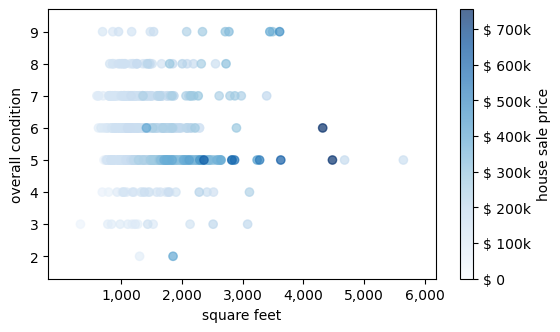

In [48]:
fig, ax = plt.subplots(figsize=(6.25, 3.5))

sp = ax.scatter(
    df.loc[y["train"].sort_values().index].iloc[:,0], df.loc[y["train"].sort_values().index].iloc[:,1],
    c=y["train"].sort_values(), alpha=.7, cmap="Blues", vmin=0, vmax=y["train"].max())
cbar = plt.colorbar(sp, ax=ax)
cbar.set_label(y["train"].name)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(float2kdollars))

ax.set_xticks(range(1_000, 7_000, 1_000), [f"{x:,.0f}" for x in range(1_000, 7_000, 1_000)])
ax.set_xlim(xlim_global)
ax.set_ylim(ylim_global)
ax.set_xlabel(X["train"].columns[0])
ax.set_ylabel(X["train"].columns[1])

fig.savefig("raw_data_scatterplot.png", dpi=200, bbox_inches="tight")

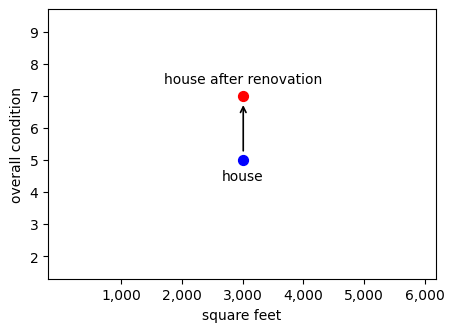

In [49]:
fig, ax = plt.subplots(figsize=(5, 3.5))

ax.scatter(3_000, 5, s=50, zorder=5, color="blue")
ax.scatter(3_000, 7, s=50, zorder=5, color="red")
ax.annotate("house", [3_000, 5-.3], ha="center", va="top")
ax.annotate("house after renovation", [3_000, 7+.3], ha="center", va="bottom")
ax.annotate("", xy=(3_000+10, 7-.2), xytext=(3_000+10, 5+.2), arrowprops=dict(arrowstyle="->", lw=1.2, color="black"))
ax.set_xticks(range(1_000, 7_000, 1_000), [f"{x:,.0f}" for x in range(1_000, 7_000, 1_000)])
ax.set_xlim(xlim_global)
ax.set_ylim(ylim_global)
ax.set_xlabel(X["train"].columns[0])
ax.set_ylabel(X["train"].columns[1])

fig.savefig("single_house_scatterplot.png", dpi=200, bbox_inches="tight")

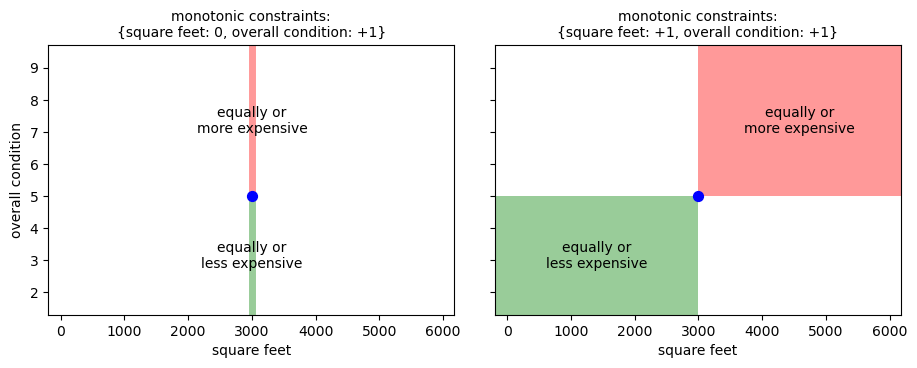

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(5 * 2 + 1, 3.5), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.10)

for en_occ, occ in enumerate(["+1"]):
    for en_sfc, sfc in enumerate(["0", "+1"]):

        ax = axs[en_sfc]
        ax.scatter(3_000, 5, s=50, zorder=5, color="blue")

        xlim_red_rectangle = [3_000, xlim_global[0] if sfc == "-1" else (xlim_global[1] if sfc == "+1" else 3_000)]
        ylim_red_rectangle = [5, ylim_global[0] if occ == "-1" else (ylim_global[1] if occ == "+1" else 5)]
        ax.fill_between(
            xlim_red_rectangle,
            ylim_red_rectangle[0],
            ylim_red_rectangle[1],
            facecolor="red",
            edgecolor="red",
            alpha=0.4,
            linewidth=5 if occ == "0" or sfc == "0" else 0,
        )
        (
            ax.annotate(
                "equally or\nmore expensive",
                [np.mean(xlim_red_rectangle), np.mean(ylim_red_rectangle)],
                ha="center",
                va="center",
            )
            if occ != "0" or sfc != "0"
            else None
        )

        xlim_green_rectangle = [3_000, xlim_global[1] if sfc == "-1" else (xlim_global[0] if sfc == "+1" else 3_000)]
        ylim_green_rectangle = [5, ylim_global[1] if occ == "-1" else (ylim_global[0] if occ == "+1" else 5)]
        ax.fill_between(
            xlim_green_rectangle,
            ylim_green_rectangle[0],
            ylim_green_rectangle[1],
            color="green",
            edgecolor="green",
            alpha=0.4,
            linewidth=5 if occ == "0" or sfc == "0" else 0,
        )
        (
            ax.annotate(
                "equally or\nless expensive",
                [np.mean(xlim_green_rectangle), np.mean(ylim_green_rectangle)],
                ha="center",
                va="center",
            )
            if occ != "0" or sfc != "0"
            else None
        )

        ax.set_title(f"monotonic constraints:\n{{square feet: {sfc}, overall condition: {occ}}}", fontsize=10)
        ax.set_xlim(xlim_global)
        ax.set_ylim(ylim_global)
        ax.set_ylabel(X["train"].columns[1]) if en_sfc == 0 else None
        ax.set_xlabel(X["train"].columns[0])

fig.savefig("constraint_combinations.png", dpi=200, bbox_inches="tight")


AttributeError: 'HistGradientBoostingRegressor' object has no attribute 'tree_'

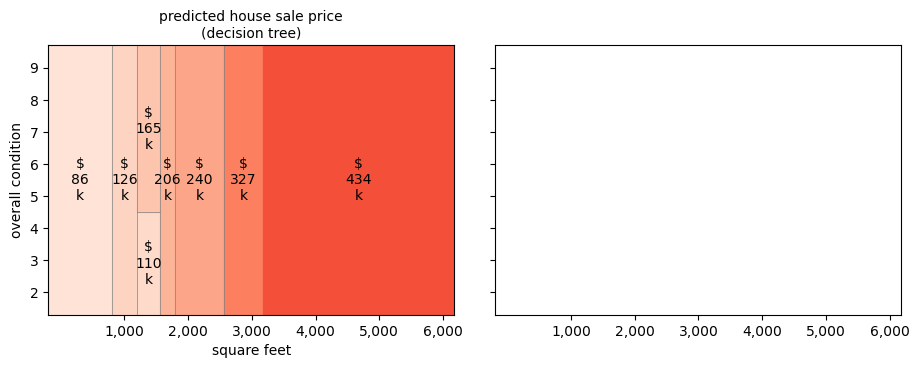

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(5 * 2 + 1, 3.5), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.10)

for en_ax, model_name in enumerate(["decision tree", "decision tree with monotonic constraints"]):

    ax = axs[en_ax]

    tree = model[model_name].tree_
    xlim = np.stack([xlim_global] * tree.node_count)
    ylim = np.stack([ylim_global] * tree.node_count)

    for en, (f, t, cl, cr) in enumerate(zip(tree.feature, tree.threshold, tree.children_left, tree.children_right)):

        if cl > 0:
            xlim[cl] = xlim[en]
            ylim[cl] = ylim[en]
        if cr > 0:
            xlim[cr] = xlim[en]
            ylim[cr] = ylim[en]

        if f == 0:
            xlim[cl, 1] = t
            xlim[cr, 0] = t
            ax.plot([t] * 2, ylim[en], lw=0.5, label=en, color="grey")
        elif f == 1:
            ylim[cr, 0] = t
            ylim[cl, 1] = t
            ax.plot(xlim[en], [t] * 2, lw=0.5, label=en, color="grey")
        else:
            ax.fill_between(
                xlim[en],
                ylim[en, 0],
                ylim[en, 1],
                color=plt.cm.Reds(tree.value.reshape(-1)[en] / y["train"].max()),
                zorder=-1,
            )
            if en_ax == 1 and round(tree.value.reshape(-1)[en] / 1000) in (157, 205, 283):
                ycoords = np.mean(ylim[en]) - 0.7
            elif en_ax == 1 and round(tree.value.reshape(-1)[en] / 1000) in (177, 247):
                ycoords = np.mean(ylim[en]) + 0.7
            else:
                ycoords = np.mean(ylim[en])
            ax.annotate(
                f"$\n{round(tree.value.reshape(-1)[en] / 1000)}\nk",
                [np.mean(xlim[en]), ycoords],
                ha="center",
                va="center",
            )

    ax.set_xticks(range(1_000, 7_000, 1_000), [f"{x:,.0f}" for x in range(1_000, 7_000, 1_000)])
    ax.set_xlim(xlim_global)
    ax.set_ylim(ylim_global)
    ax.set_xlabel(X["train"].columns[0])
    ax.set_ylabel(X["train"].columns[1]) if en_ax == 0 else None
    ax.set_title(f"predicted {y['train'].name}\n({model_name})", fontsize=10)

fig.savefig("decision_tree_heatmap.png", dpi=200, bbox_inches="tight")


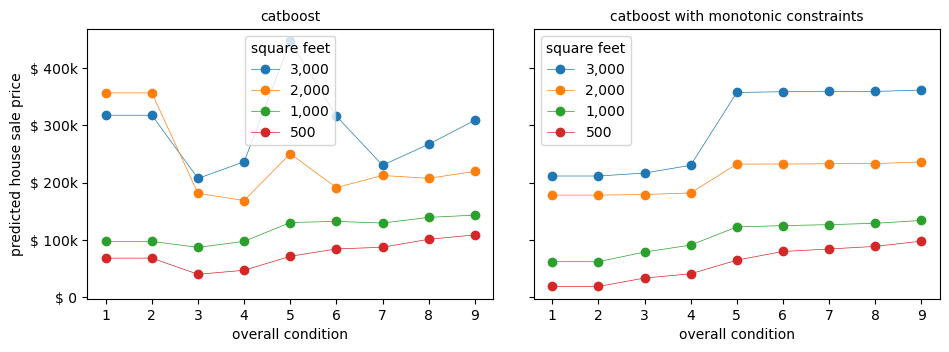

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(5 * 2 + 1, 3.5), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.10)

for en_ax, model_name in enumerate(["catboost", "catboost with monotonic constraints"]):
    ax = axs[en_ax]
    for square_feet in [3_000, 2_000, 1_000, 500]:
        ax.plot(
            range(1, 10),
            model[model_name].predict([[square_feet, overall_condition] for overall_condition in range(1, 10)]),
            marker="o",
            lw=0.5,
            label=f"{square_feet:,.0f}",
        )
    ax.set_title(model_name, fontsize=10)
    ax.set_xticks(range(1, 10))
    ax.set_xlabel("overall condition")
    ax.legend(title="square feet")
    ax.set_ylabel(f"predicted {y['train'].name}") if en_ax == 0 else None
    (
        ax.set_yticks(range(0, 500_000, 100_000), [float2kdollars(y) for y in range(0, 500_000, 100_000)])
        if en_ax == 0
        else None
    )

fig.savefig("catboost_simulation.png", dpi=200, bbox_inches="tight")
